**결정 트리(decision tree)** : 분류와 회귀 작업 그리고 다중출력도 작업도 가능한 다재다능한 머신러닝 알고리즘
+ 랜덤 포레스트의 기본 구성 요소

## 6.1 결정 트리 학습과 시각화

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

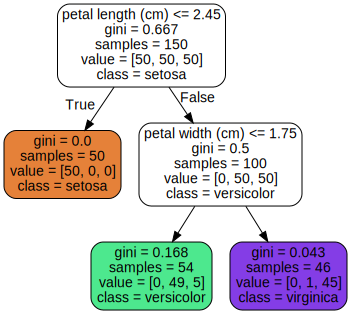

In [3]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

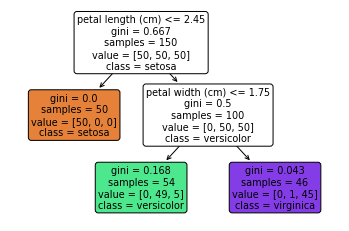

In [4]:
# plot_tree() 를 이용해 그리는 방법
from sklearn.tree import plot_tree
plot_tree(tree_clf,
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True)
plt.show()

## 6.2 예측하기

결정 트리 -> 데이터의 전처리가 거의 필요하지 않음  
사이킷런은 이진 트리만 만드는 CART 알고리즘을 사용하기에 리프 노드 외의 모든 노드는 자식 노드를 두 개씩 가짐  

**루트 노드(root node)** : 깊이가 0인 맨 꼭대기의 노드  

**리프 노드(leaf node)** : 자식 노드를 가지지 않는 노드  

**노드(node)**
+ sample 속성 : 얼마나 많은 훈련 샘플이 적용되었는지 헤아린 것
+ value 속성 : 노드에서 각 클래스에 얼마나 많은 훈련 샘플이 있는지 알려줌
+ gini 속성 : 불순도를 측정

**지니 불순도(gini impurity)**
+ 한 노드의 모든 샘플이 같은 클래스에 속해 있다면 이 노드를 순수(gini=0)하다고 함
+ $G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}$ ($p_{i,k}$는 $i$번째 노드에 있는 훈련 샘플 중 클래스 $k$에 속한 샘플의 비율)

**화이트박스 모델(white box model)** : 직관적이고 결정 방식을 이해하기 쉬움

**블랙박스 모델(black box model)** : 성능이 뛰어나고 예측을 만드는 연산 과정을 쉽게 확인할 수 있지만 왜 그런 예측을 만드는지는 쉽게 설명 불가

<img src="img/6-2.png" width="500px" align='left'>  

## 6.3 클래스 확률 추정

결정 트리는 특정 클래스 $k$에 속할 확률을 추정 가능
+ 리프 노드를 찾기 위해 트리를 탐색하고 그 노드에 있는 클래스 $k$의 훈련 샘플의 비율을 반환

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

## 6.4 CART 훈련 알고리즘

**CART(classification and regression tree) 알고리즘**
+ 탐욕적 알고리즘(greedy algorithm)
    + 맨 위 루트 노드에서 최적의 분할을 찾으며 이어지는 각 단계에서 이 과정을 반복(최적의 솔루션을 보장하지는 않음)
+ 훈련 세트를 하나의 특성 $k$의 임계값 $t_k$를 사용해 두 개의 서브셋으로 나눔
+ 가장 순수한 서브셋으로 나눌 수 있는 $(k, t_k)$ 짝을 찾음
+ 훈련 세트를 성공적으로 둘로 나누었다면 같은 방식으로 서브셋을 계속 나누며 반복
+ 최대 깊이가 되면 중지하거나 불순도를 줄이는 분할을 찾을 수 없을 때 중지

**분류에 대한 CART 비용 함수**

$\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{여기에서 }\begin{cases}
G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도}\\
m_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
\end{split}$

## 6.5 계산 복잡도

결정 트리를 탐색하기 위해서는 약 $O(log_2(m))$개의 노드를 거쳐야 함

## 6.6 지니 불순도 또는 엔트로피?

**엔트로피(entropy) 불순도**
+ 엔트로피 : 분자의 무질서함을 측정하는 열역학 개념. 안정되고 질서 정연하면 0에 가까움
+ criterion 매개변수를 'entropy'로 지정하여 사용
+ 정보 이득(information gain) : 감소되는 엔트로피의 양
+ 지니 불순도와 큰 차이가 없긴 하지만 기본적으로 지니 불순도가 조금 더 빠름
+ 지니 불순도가 가장 빈도 높은 클래스를 한쪽 가지로 고립시키는 경향이 있는 반면 엔트로피는 조금 더 균형 잡힌 트리를 만듦
+ $H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}$

## 6.7 규제 매개변수

**비파라미터 모델(nonparametric model)**
+ 모델 파라미터가 전혀 없는 것이 아니라 훈련되기 전에 파라미터 수가 결정되지 않음
+ 모델 구조가 데이터에 맞춰져서 고정되지 않고 자유로움
+ e.g. 결정 트리

**파라미터 모델(parametric model)**
+ 미리 정의된 모델 파라미터 수를 가지므로 자유도가 제한되고 과대적합될 위험이 줄어듬(과소적합 위험은 커짐)
+ e.g. 선형 모델

**규제** : 훈련 데이터에 대한 과대적합을 피하기 위해 학습할 때 결정 트리의 자유도를 제한
+ min_ 매개변수를 증가시키거나 max_ 매개변수를 감소시키면 규제가 커짐
+ max_depth : 결정 트리의 최대 깊이 제어
+ min_samples_split : 분할되기 위해 노드가 가져야 하는 최소 샘플 수
+ min_samples_leaf : 리프 노드가 가지고 있어야 할 최소 샘플 수
+ min_weight_fraction_leaf : min_samples_leaf 와 같지만 가중치가 부여된 전체 샘플 수에서의 비율
+ max_leaf_nodes : 리프 노드의 최대 수
+ max_features : 각 노드에서 분할에 사용한 특성의 최대 수

```python
#왼쪽 : 기본 매개변수  
#오른쪽 : min_samples_leaf = 4로 지정하여 훈련
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
```
왼쪽은 과대적합되었고, 오른쪽 모델은 일반화 성능이 더 좋아보임

<img src="img/6-3.png" width="500px" align='left'>

**가지치기(pruning)**
+ $\chi^2$ 검정(chi-squard test) 같은 통계적 검정을 사용하여 우연히 향상된 것인지 추정(귀무가설)
+ $p$ 값이 어떤 임계값보다 높으면 그 노드는 불필요한 것으로 간주되고 그 자식 노드는 삭제
+ 불필요한 노드가 모두 없어질 때까지 계속


## 6.8 회귀

**DecisionTreeRegressor**
+ 각 노드에서 클래스를 예측하는 대신 어떤 값을 예측
+ 각 영역의 예측값은 항상 그 영역에 있는 타깃값의 평균

CART 알고리즘은 훈련 세트를 불순도를 최소화하는 방향으로 분할하는 대신 평균제곱오차(MSE)를 최소화하도록 분할

In [7]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

그림 저장: tree_regression_plot


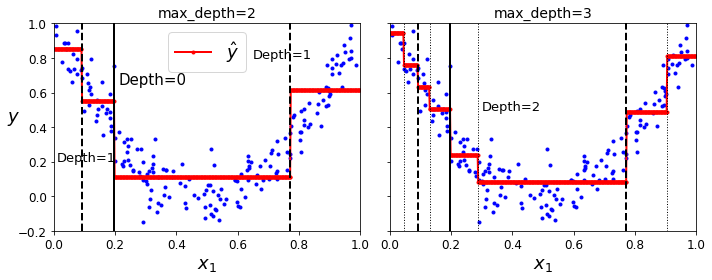

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

In [10]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

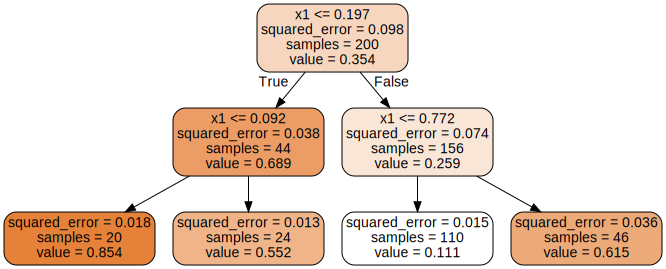

In [11]:
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

## 6.9 불안정성

결정 트리는 계단 모양의 결정 경계를 만들기 때문에 훈련 세트의 회전에 민감 -> PCA 기법(훈련 데이터를 더 좋은 방향으로 회전시킴)
+ left : 쉽게 데이터셋을 구분
+ right : 45도 회전한 상태. 불필요하게 구불구불함

<img src="img/6-7.png" width="500px" align='left'>

훈련 데이터에 있는 작은 변화에도 매우 민감(가장 큰 값 1개를 제거한 상태)

<img src="img/6-8.png" width="500px" align='left'>